In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import operator

from util.api import get_added_packages_mtl_by_lts,get_removed_packages_mtl_by_lts, get_packages_started_use_mtl, get_packages_stopped_use_mtl,build_mtl_continuity_matrix,get_all_time_packages

%matplotlib inline
plt.style.use('classic')

In [10]:
lts_list = ['0-7', '2-22', '3-22', '6-35', '7-24', '9-21', '11-22', '12-14', '12-26', '13-11', '13-19', '14-27', '15-3', '16-11']
df_list = []
df_by_category_list = []

for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}.df')
    df_list.append(df)
    
for idx, lts in enumerate(lts_list):
    df = pd.read_pickle(f'../../data/lts-{lts}/lts-{lts}-by-category.df')
    df_by_category_list.append(df)

# Research Questions (RQs)

- **RQ 1.** What packages are the most used? Which of them are outside from the Stackage selection?
- **RQ 2.** How many dependencies of packages are outside from the Stackage selection (in)directly?
- **RQ 3.** How frequently are the packages updated? 

Regarding monads, we analyze the evolution of dependencies of monad modules available in the mtl package:

- **RQ 4.** How has the use of monads evolved?
- **RQ 5.** Are there packages that stopped using monads?

## RQ 5.  How many packages that depend of mtl were removed? Are there packages that stopped using monads ?

How many packages that depend of mtl were removed? - Para saber cuantos paquetes fueron removidos que dependen de mtl tambien nos gustaria hacer la compracion con los que fueron agregados. Para esto creamos un DataFrame de continuidad de los paquetes que nos indica que paquete existe en la version y ademas, si utiliza monadas en aquel momento. Luego, iteramos sobre este DataFrame para contar cuantos paquetes se removieron y agregaron en cada version. Tranformamos los valores contabilizados a su forma porcentual respecto a la cantidad total de paquetes en la version. Finalmente, utilizamos graficos de linea para visualizar la fructuacion en el tiempo de los paquetes removidos versus los agregados, con apoyo de un grafico de barra para visualizar el valor final en cada LTS.

Pregunta 1
- La primera version parte con 175 paquetes que usan mtl (Agregar o no la primera version)
- al comienzo hubo una tendencia de crecimiento en la cantidad de paquetes que se agregaban que utilizaban mtl, pero esto puede tener relacion con la cantiad de paqutes que se agregaron en aquel momento.
- Sin embargo vemos una fluctuacion de paquetes agregados y removidos de mtl importantes, pj en la version 11-22 que se agregaron alrededor de 75 paquetes pero se removieron 115, el movimiento de paquetes es importate.
- Posterior a las 4 primeras versinones, la suma total de paquetes removidos es mayor a la cantidad de paquete agregados

Pregunta 2
- Este caso no sucede muy amenudo
- La mayor fluctuacion la vemos en la lts 9-21, en donde 10 paquetes comenzaron a usar mtl y 6 dejaron de usar mtl
- Son tan pocos los casos que no se puede asegurar una tendencia
- Inclusive durante el periodo 12-26 - 13-19 no existe ninguna variacion (lts's con poco margen de tiempo)
- Se cree que este cambio no fue tan drastico porque el lenguaje empuja a mantener el uso de monadas y no existe hasta ahora un cambio pragmatico en la programacion de este.

In [11]:
mtl_continuity_df = build_mtl_continuity_matrix(df_list, get_all_time_packages(df_list))

In [12]:
added_mtl_pkgs_count = get_added_packages_mtl_by_lts(mtl_continuity_df)
removed_mtl_pkgs_count = get_removed_packages_mtl_by_lts(mtl_continuity_df)
total = [(x - y) for idx, (x, y) in enumerate(zip(added_mtl_pkgs_count, removed_mtl_pkgs_count))]

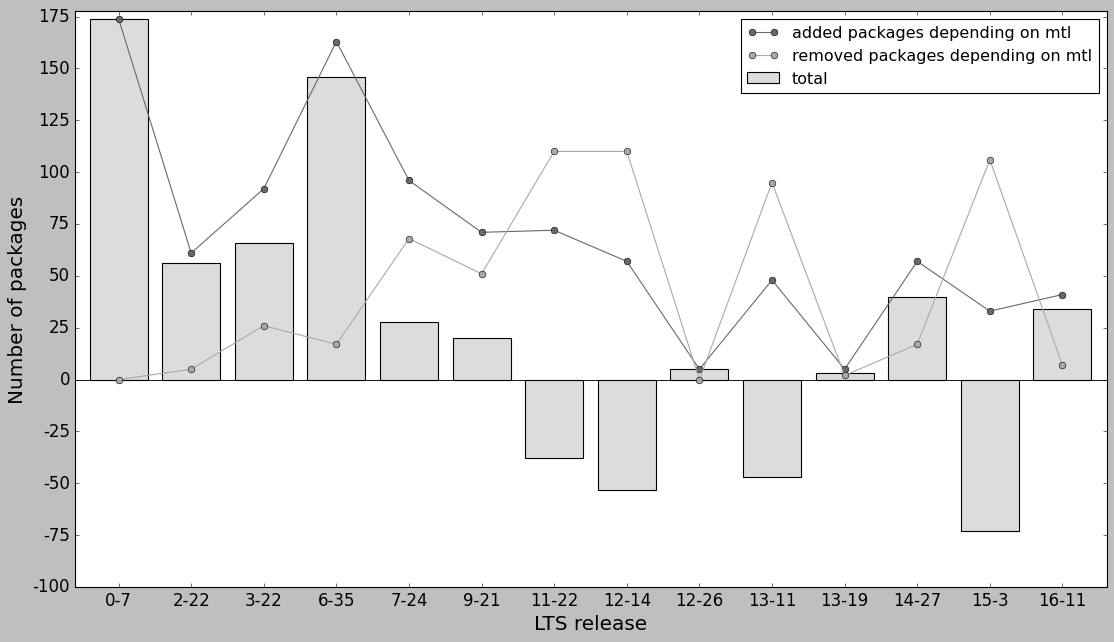

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(bottom=0.1, right=1.2, top=1)
ax.axhline(0, color='black', linewidth=0.8)
bar = ax.bar(lts_list, total, width=0.8, color='gainsboro', align='center', label='total')
line = ax.plot(lts_list, added_mtl_pkgs_count, color='dimgrey', marker='o', label='added packages depending on mtl')
line = ax.plot(lts_list, removed_mtl_pkgs_count, color='darkgrey', marker='o', label='removed packages depending on mtl')
ax.legend(loc='best')
ax.set_xlabel('LTS release',fontsize=18)
ax.set_ylabel('Number of packages',fontsize=18)
ax.set_xticks(lts_list)
ax.set_xticklabels(lts_list,fontsize=15)
ax.set_yticks([-100, -75, -50, -25, 0, 25, 50, 75, 100, 125, 150, 175])
ax.set_yticklabels(['-100', '-75', '-50', '-25', '0', '25', '50', '75', '100', '125', '150', '175'],fontsize=15)
plt.savefig("../../graphs/rq5_1.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [14]:
packages_started_use_mtl_count = get_packages_started_use_mtl(mtl_continuity_df)
packages_stopped_use_mtl_count = get_packages_stopped_use_mtl(mtl_continuity_df)
total = [(x - y) for idx, (x, y) in enumerate(zip(packages_started_use_mtl_count, packages_stopped_use_mtl_count))]

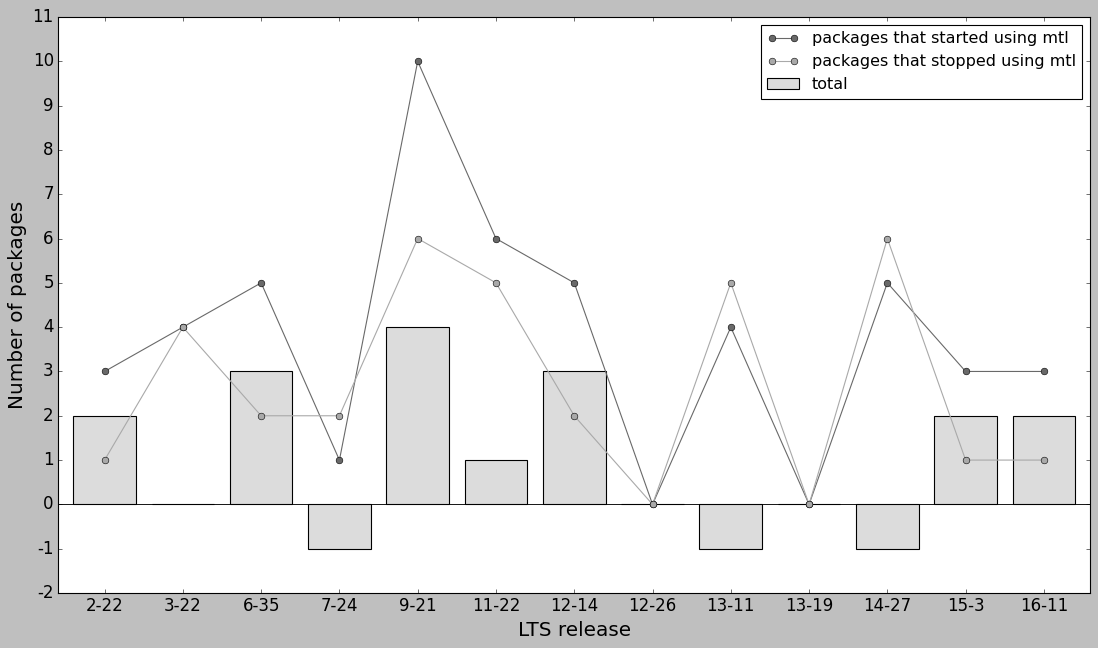

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
ax.margins(0.015) 
plt.subplots_adjust(bottom=0.1, right=1.2, top=1)
ax.axhline(0, color='black', linewidth=0.8)
bar = ax.bar(lts_list[1:], total[1:], width=0.8, color='gainsboro', align='center', label='total')
line = ax.plot(lts_list[1:], packages_started_use_mtl_count[1:], color='dimgrey', marker='o', label='packages that started using mtl')
line = ax.plot(lts_list[1:], packages_stopped_use_mtl_count[1:], color='darkgrey', marker='o', label='packages that stopped using mtl')
ax.legend(loc='best')
ax.set_xlabel('LTS release',fontsize=18)
ax.set_ylabel('Number of packages',fontsize=18)
ax.set_xticks(lts_list[1:])
ax.set_xticklabels(lts_list[1:],fontsize=15)
ax.set_yticks([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
ax.set_yticklabels(['-2', '-1', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],fontsize=15)
plt.savefig("../../graphs/rq5_2.pdf", format='pdf', bbox_inches='tight')
plt.show()